In [ ]:

def __slices_wholelogic(hub, key='', axes=[[]], N=100, tid=0, idx=0,Region=0):
    '''
    Take the logic of a field, and calculate a slice given two of the argument fields that are modified

    Example :
        plotfunction(hub,key='Hid',axes=[['Omega',0,2]],N=100,tid=0,idx=0)
        plotfunction(hub,key='Hid',axes=[['Omega',0,2],['x',0,100]],N=100,tid=0,idx=0)

    Parameters
    ----------
    key  : str. name of the field you are introspecting
    axes : [[str,valmin,valmax]] or [[str,valmin,valmax],[str,valmin,valmax]] for 2D
    N    : int, number of points in grid
    tid  : index of
    idx : TYPE, optional
        DESCRIPTION. The default is 0.

    Raises
    ------
    Exception
        DESCRIPTION.

    Returns
    -------
    None.
    '''

    R = hub.get_dparam()

    if len(axes) > 2:
        raise Exception('Too many dimensions to plot !')
    elif len(axes) == 2:
        axx = axes[0]
        axy = axes[1]

        ## If the axes contains a sector
        if len(axx)==4: RegionX=axx[1]
        else : RegionX=0
        if len(axy)==4: RegionY=axy[1]
        else : RegionY=0

        ### CREATE THE GRID
        XX, YY = np.meshgrid(np.linspace(axx[-2], axx[-1], N),
                             np.linspace(axy[-2], axy[-1], N))


        keys = [axes[0][0], axes[1][0]]
        defaultkeys = [k for k in R[key]['kargs'] if k not in keys]

        defaultval = {k: R[k]['value'] for k in defaultkeys if k in hub.dmisc['parameters']}
        defaultval.update({k: R[k]['value'][tid, idx,Region,:,0]
                          for k in defaultkeys if k in hub.dmisc['dfunc_order']['statevar']})
        defaultval0 = copy.deepcopy(defaultval)
        defaultval[keys[0]][:,RegionX] = XX
        defaultval[keys[1]][:,RegionY] = YY

        Z = R[key]['func'](**defaultval)

        plt.figure(f'Function: {key} 2D')
        plt.pcolormesh(XX, YY, Z, cmap='jet')
        plt.xlabel(R[axes[0][0]]['symbol'])
        plt.ylabel(R[axes[1][0]]['symbol'])
        plt.title(R[key]['symbol']+f'\n {defaultval0}')
        plt.colorbar()
        plt.show()
    elif len(axes) == 1:
        XX = np.linspace(axes[0][1], axes[0][2], N)
        if len(axes[0])==4: RegionX=axes[0][1]
        else : RegionX=0

        defaultkeys = [k for k in R[key]['kargs'] if k not in [key]]

        defaultval = {k: R[k]['value'] for k in defaultkeys if k in hub.dmisc['dfunc_order']['parameters']}

        defaultval.update({k: R[k]['value'][tid, idx,Region,:,0]
                          for k in defaultkeys if k in hub.dmisc['dfunc_order']['statevar']})
        defaultval0 = copy.deepcopy(defaultval)

        defaultval[axes[0][0]][:] = XX

        Z = R[key]['func'](**defaultval)

        plt.figure(f'Function: {key} 1D')
        plt.plot(XX, Z)
        plt.xlabel(R[axes[0][0]]['symbol'])
        plt.ylabel(R[key]['symbol'])
        plt.title(f'{defaultval0}')
        plt.show()


def __plot_variation_rate(hub, varlist, title='', idx=0):
    '''
    Allow one to observe the time variation and the contribution of each dependency.
    Useful for debugging or understanding where are the main loops

    THE SYSTEM NEEDS :
        1) a run
        2) calculate_variation_rate

    for each field in varlist (ex : ['Y','L','w']) it will :
        * Print the variable time evolution
        * Print its relative growth rate
        * if it is a Statevar, its time derivate, and the contribution of each of its dependency to its time derivate
        * if it is an ODE, its second time derivate and the contribution of each of its dependency
    '''
    R = hub.get_dparam()

    fig = plt.figure()
    fig.set_size_inches(15, 5*len(varlist))
    t = R['time']['value'][:, 0]
    gs = GridSpec(len(varlist), 3)

    # Axis for value and relative growth
    ax0 = {key: fig.add_subplot(gs[i, 0]) for i, key in enumerate(varlist)}
    ax02 = {key: ax0[key].twinx() for key in varlist}

    # Axis for derivative and their contributions
    ax = {key: fig.add_subplot(gs[i, 1:]) for i, key in enumerate(varlist)}

    for key in varlist:
        # ##################################
        # Left Curves (y, relative growth)
        ax02[key].plot(t, R[key]['value'][:, idx], c='b')
        ax0[key].plot(t[1:-1], R[key]['time_log_derivate'][1:-1, idx], ls='--', c='g')
        ax0[key].axhline(y=0, color='k', lw=0.5)

        # Ylim management
        sort = np.sort(R[key]['time_log_derivate'][1:-1, idx])[int(0.05*len(t)):-int(0.05*len(t))]
        ax0[key].set_ylim([1.3*np.nanmin(sort), 1.3*np.nanmax(sort)])
        # Left side axis management
        ax02[key].set_ylabel(R[key]['symbol'])
        ax02[key].spines['left'].set_position(('outward',  80))

        ax02[key].yaxis.tick_left()
        ax02[key].yaxis.set_label_position('left')
        ax02[key].spines['left'].set_color('blue')
        ax02[key].tick_params(axis='y', colors='blue')
        symb = R[key]['symbol'].replace('$', '')
        label = r'$\dfrac{\dot{'+symb+r'}}{'+symb+'}$'
        ax0[key].spines['left'].set_color('green')
        ax0[key].tick_params(axis='y', colors='green')
        ax0[key].set_ylabel(label)

        # ##################################
        # Right side (Derivates)

        # Full curve
        if R[key]['eqtype'] == 'ode':
            ax[key].plot(t[2:-2], R[key]['time_dderivate'][2:-2, idx],
                         c='black', label=r'$\dfrac{d^2 '+symb+r'}{dt^2}$')
            label = r'$\ddot{'+R[key]['symbol'].replace('$', '')+r'}$'
        else:
            ax[key].plot(t[1:-1], R[key]['time_derivate'][1:-1, idx],
                         c='black', label=r'$\dfrac{d '+symb+r'}{dt}$')
            label = r'$\dot{'+R[key]['symbol'].replace('$', '')+r'}$'
        ax[key].spines['right'].set_color('black')
        ax[key].axhline(y=0, color='k', lw=0.5)

        #  Contribution
        vv = R[key]['partial_contribution']
        for i, k2 in enumerate(vv.keys()):
            symb2 = R[k2]['symbol'].replace('$', '')
            if R[key]['eqtype'] == 'ode':
                lab = r'$\dfrac{\partial \dot{'+symb+r'}}{\partial '+symb2+'}\dot{'+symb2+r'}$'
            else:
                lab = r'$\dfrac{\partial '+symb+r'}{\partial '+symb2+'}\dot{'+symb2+r'}$'
            ax[key].plot(t[1:-1], vv[k2][1:-1, idx],
                         label=lab)

        # Axis management
        ax[key].yaxis.tick_right()
        ax[key].yaxis.set_label_position('right')
        ax[key].set_ylabel(label)
        ax[key].legend()

    # Figure management
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle(title)
    plt.show() 

In [ ]:
import numpy as np 
import matplotlib.plotly as plt 

In [26]:
x = 'omega'
y = 'employment'
width = '_speed'
color = 'g'
xlim = [0,.99]
ylim = [0,.99]
title='Test'

R = hub.get_dfields()

X,Y = np.meshgrid(np.linspace(xlim[0],xlim[1],30), #OMEGA   
                np.linspace(ylim[0],ylim[1],30)) #EMPLOYMENT
X.reshape(-1)
Y.reshape(-1)

employment = Y
omega= Y

nu=3
delta = 0.05
alpha = 0.02
n = 0.025
phillips = -0.1 + 0.01/(1-employment)**2
pi = 1 - omega


dXdt = omega * (phillips - alpha)
dYdt = employment * ((1 - omega) / nu - alpha - n - delta)

speed = (dXdt**2 + dYdt**2)**(1/2)
g = (1 - X) / nu - delta

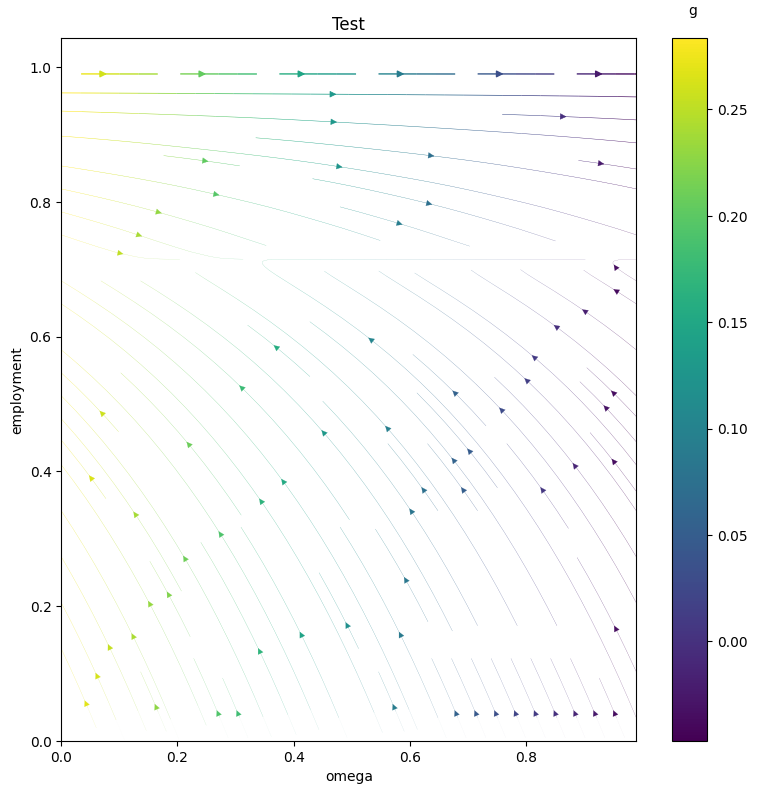

In [29]:
lw = (speed / speed.max())**(1/4)

fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(8)
strm =plt.streamplot(X, Y, dXdt, dYdt, density=1, color=g, linewidth=lw)
cb = fig.colorbar(strm.lines)
cb.set_label(color, labelpad=-40, y=1.05, rotation=0)

plt.xlabel(x)
plt.ylabel(y)

plt.title(title)
plt.tight_layout()
plt.show()